In [65]:
## python -m virtualenv -p python3.12 .venv
# !python -m pip install torch torchvision torchaudio
# !pip install tensorboard
# !pip install onnx
# !pip install onnxscript
# !python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# !pip install matplotlib
# !pip install onnxruntime

In [93]:
import torch
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [67]:
# Importer Un dataset préfait (MNIST)

training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [68]:
print(training_dataset)
print(training_dataset.data.shape)
print(training_dataset.targets.shape)
print(training_dataset.targets.unique())
print(training_dataset.targets.bincount())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


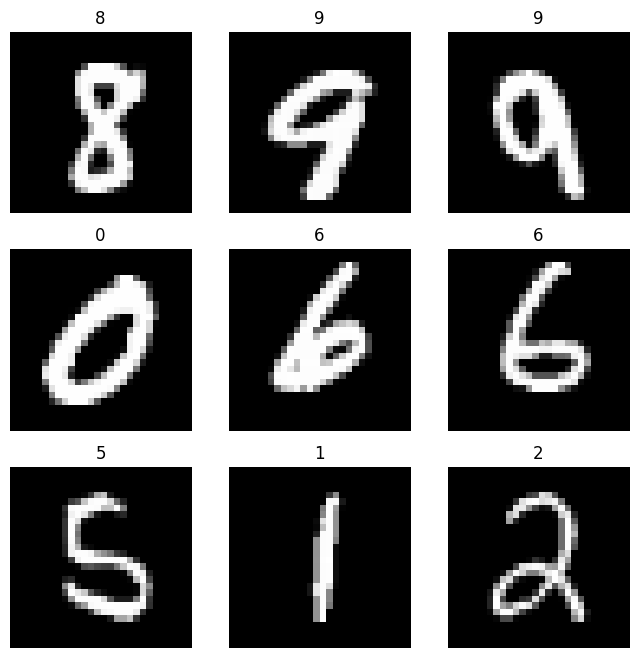

In [69]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [70]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"shape X : {X.shape}")
    print(f"y shape: {y.shape}")
    break

shape X : torch.Size([64, 1, 28, 28])
y shape: torch.Size([64])


In [71]:
train_features, train_labels = next(iter(train_dataloader))
train_features.shape

torch.Size([64, 1, 28, 28])

In [72]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, dims):
        super(MLP, self).__init__()
        self.fcs = nn.ModuleList(
            [nn.Linear(dims[i], dims[i+1]) for i in range(len(dims)-1)]
        )
        self.act = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x) #1 * 28 * 28 -> 1 * 784 
        for layer in self.fcs:
            x  = layer(x)
            x = self.act(x)
        return x

In [73]:
input_dim = 28*28
output_dim = 10 #Nombre de classe
model = MLP([input_dim, 128, 128, output_dim])

In [74]:
model

MLP(
  (fcs): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [75]:
loss_fn = nn.CrossEntropyLoss() # Expect raw logits (!= probabilities)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) 

In [76]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    for batch, (X, y) in enumerate(dataloader):

        #Prédiction
        ypred = model(X)
        loss = loss_fn(ypred, y) #Calcul de l'erreur

        #backpropagation
        loss.backward()
        optimizer.step() #W = W - lr * grad
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size * len(X)
            print(f'loss {loss:>7f} [{current:>5d}/{len(dataloader.dataset)}]')

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            ypred = model(X)
            test_loss += loss_fn(ypred, y).item()
            correct += (ypred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss/= len(dataloader)
    correct/=len(dataloader.dataset)
    print(f"Test loss: {test_loss:>8f} | test accuracy {(correct * 100):>7f}")

In [77]:
# epochs = 10
# for t in range(epochs):
#     print(f"Epoch {t+1} ------------------------")
#     train_loop(train_dataloader, model, loss_fn, optimizer)
#     test_loop(test_dataloader, model, loss_fn)
# print("Done!")

In [78]:
# training_dataset = datasets.MNIST(
#     root="data",
#     train=True,
#     download=True,
#     transform=T.ToTensor()
# )

# test_dataset = datasets.MNIST(
#     root="data",
#     train=False,
#     download=True,
#     transform=T.ToTensor()
# )

In [ ]:
# from torch.utils.data import ConcatDataset

# mean, std = 0,0
# combined_datasets = ConcatDataset([training_dataset, test_dataset])

# for image, label in combined_datasets:
#     image = image.view(28*28) 
#     mean = image.mean().sum()
#     std += image.std().sum()

# mean/= len(combined_datasets)
# std/=len(combined_datasets)

# print(f'Mean : {mean}')
# print(f'Variance : {std}')

Mean : 2.989267386510619e-06
Variance : 0.30183959007263184


In [80]:
training_dataset_v2 = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=T.Compose([T.ToTensor(),T.Normalize((mean),(std))])
)

test_dataset_v2 = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.Compose([T.ToTensor(),T.Normalize((mean),(std))])
)

In [81]:
from torch.utils.data import ConcatDataset

mean, std = 0,0
combined_datasets = ConcatDataset([training_dataset_v2, test_dataset_v2])

for image, label in combined_datasets:
    image = image.view(28*28) 
    mean = image.mean().sum()
    std += image.std().sum()

mean/= len(combined_datasets)
std/=len(combined_datasets)

print(f'Mean : {mean}')
print(f'Variance : {std}')

Mean : 9.903354111884255e-06
Variance : 0.9999989867210388


In [82]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader_v2 = DataLoader(training_dataset_v2, batch_size=batch_size, shuffle=True)
test_dataloader_v2 = DataLoader(test_dataset_v2, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"shape X : {X.shape}")
    print(f"y shape: {y.shape}")
    break

shape X : torch.Size([64, 1, 28, 28])
y shape: torch.Size([64])


In [83]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1} ------------------------")
    train_loop(train_dataloader_v2, model, loss_fn, optimizer)
    test_loop(test_dataloader_v2, model, loss_fn)
print("Done!")

Epoch 1 ------------------------
loss 2.301116 [    0/60000]
loss 1.317920 [409600/60000]
loss 1.116725 [819200/60000]
loss 1.132330 [1228800/60000]
loss 1.377505 [1638400/60000]
loss 1.021364 [2048000/60000]
loss 1.055431 [2457600/60000]
loss 0.919061 [2867200/60000]
loss 1.229847 [3276800/60000]
loss 1.220198 [3686400/60000]
Test loss: 1.067155 | test accuracy 56.540000
Epoch 2 ------------------------
loss 0.871453 [    0/60000]
loss 0.799095 [409600/60000]
loss 1.060146 [819200/60000]
loss 0.941705 [1228800/60000]
loss 1.025890 [1638400/60000]
loss 1.037637 [2048000/60000]
loss 1.237923 [2457600/60000]
loss 1.082995 [2867200/60000]
loss 1.081439 [3276800/60000]
loss 1.032664 [3686400/60000]
Test loss: 1.049539 | test accuracy 56.730000
Epoch 3 ------------------------
loss 0.969851 [    0/60000]
loss 1.132389 [409600/60000]
loss 1.160665 [819200/60000]
loss 0.918874 [1228800/60000]
loss 0.778607 [1638400/60000]
loss 1.151304 [2048000/60000]
loss 0.937052 [2457600/60000]
loss 0.9099

In [84]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Accélérateur: {device}')

Accélérateur: cuda


In [128]:
# input_dim = 28*28
# output_dim = 10 #Nombre de classe
# model = MLP([input_dim, 128, 128, output_dim]).to(device)

# loss_fn = nn.CrossEntropyLoss().to(device) # Expect raw logits (!= probabilities)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) 

In [147]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('run/mnist_experiment_11')

def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    model.train()
    epoch_loss = 0
    correct = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss / len(dataloader), correct / len(dataloader.dataset) * 100

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return test_loss / len(dataloader), correct / len(dataloader.dataset) * 100

# Training loop with added graphing
def train_and_test(dataloader_train, dataloader_test, model, loss_fn, optimizer, epochs, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model
        train_loss, accuracy = train_loop(dataloader_train, model, loss_fn, optimizer, batch_size)
        writer.add_scalars('Loss', {'train': train_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': accuracy}, epoch)

        # Test the model
        test_loss, accuracy = test_loop(dataloader_test, model, loss_fn)
        writer.add_scalars('Loss', {'test': test_loss}, epoch)
        writer.add_scalars('Accuracy', {'test': accuracy}, epoch)

        print(f"Epoch {epoch+1}/{epochs} complete\n")

# train_and_test(train_dataloader_v2, test_dataloader_v2, model, loss_fn, optimizer, epochs, batch_size)

In [148]:
# %load_ext tensorboard
# %tensorboard --logdir=runs
# #voir les logs

In [149]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), #1 * 28 *28 -> 32 * 28 * 28
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), #32 * 28 *28 -> 64 * 28 * 28
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(kernel_size=2,stride=2) #64 * 28 *28 -> 64 * 14 * 14
        )
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self,x):
        x = self.conv_stack(x)
        x = self.mlp(x)
        return x

In [150]:
cnn  = CNN().to(device)
loss_fn = nn.CrossEntropyLoss().to(device) # Expect raw logits (!= probabilities)
optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-3)

In [151]:
epochs = 1
train_and_test(train_dataloader_v2, test_dataloader_v2, cnn, loss_fn, optimizer, epochs, batch_size)

Epoch 1/1
Epoch 1/1 complete



In [152]:
%load_ext tensorboard
%tensorboard --logdir=runs
#voir les logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17968), started 1:16:40 ago. (Use '!kill 17968' to kill it.)

In [153]:
cnn.to('cpu')
torch_input = torch.randn(1,1,28,28) # n, c , L, T
onn_program = torch.onnx.export(
    cnn,
    torch_input,
    "model.onnx",
    verbose=True,
    input_names=["input"],
    output_names=["output"],
    opset_version=11, # /!\
    export_params=True,
    do_constant_folding=True,
    dynamic_axes={
        "input":{0:"batch_size"},
        "output":{0:"batch_size"}
    }
)

In [154]:
import onnxruntime
# ort_sessions = onnxruntime .... et le reste je l'ai pas
# https://pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html#compare-the-pytorch-results-with-the-ones-from-the-onnx-runtime

onnx_input = [torch_input]
print(f"Input length: {len(onnx_input)}")
print(f"Sample input: {onnx_input}")

ort_session = onnxruntime.InferenceSession("./model.onnx", providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

# onnxruntime returns a list of outputs
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)[0]

Input length: 1
Sample input: [tensor([[[[-1.6477e+00,  1.6330e+00, -4.7823e-03,  6.3573e-01, -9.9606e-01,
            1.2458e+00, -4.0261e-01,  5.2798e-01,  2.1038e+00, -2.3587e-01,
           -1.2092e+00, -1.2500e-01, -2.9541e-01,  8.2340e-01,  4.3593e-01,
            1.2053e+00,  1.5871e+00,  4.9679e-01, -5.0570e-02,  1.1742e+00,
           -1.1369e+00,  5.1194e-01, -6.3939e-02,  1.2386e+00,  3.3472e-01,
           -1.0642e+00, -8.0183e-01, -6.2074e-01],
          [ 2.5839e-01,  4.7886e-01, -3.8655e-01, -1.6217e-01, -4.0382e-01,
            1.7971e+00,  1.2729e+00,  3.9250e-02, -1.5724e-01,  5.5973e-02,
           -1.3233e-02, -1.7176e-01,  1.2943e+00,  1.6034e+00, -2.0226e+00,
           -2.2046e-01, -1.4912e-01, -7.5612e-01,  9.5081e-01, -5.9914e-01,
           -6.4623e-01,  1.6136e-01, -2.1326e+00,  8.9788e-01, -8.3814e-02,
           -5.7917e-01, -5.8826e-01, -4.9915e-01],
          [ 9.3704e-02,  1.0624e+00, -1.7228e+00, -4.5936e-01, -1.4044e+00,
           -1.1697e+00,  1.9277